# **Build your first neural network for digit recognition and learn about hyperparameter tuning**

This is a first in a series of deep learning projects. 

In this first step we'll build a simple neural network that performs a digit recognition (you input an image containing a digit and it predicts what that digit is). And more importantly we'll be introduced to pytorch and explore its main modules.

Just before we dive into it I may need to give a general overview of deep learning and neural networks. Although I assume that the reader has a background on this field it's useful to lay out the things we're doing for better readability.

### What is deep learning ? 

So deep learning can be considered as a subfield of machine learning, and neural networks are the backbone of deep learning. And machine learning in general is about giving machines the ability to learn through experience, a common way to differentiate machine learning and traditional programming is to say that: 
  - in classical programming we provide the machine with the rules (that are human produced), and in execution time we give the machine an input and it provides us with the desired output.
  - Whereas in machine learning, we provide the machine with a set of examples of inputs and desired outputs that it can learn from. Using those examples the machine produces the rules for itself and that it can hopefully use in the future.

![traditioanl programming vs machine learning](https://lucid.app/publicSegments/view/7c5b473f-07f5-468d-ae7e-271b3e0aaec0/image.png)

As we said deep learning is no different. So let's just focus on DL since it's the our main topic.

Now on every DL algorithm we'll find 4 main components that are absolutely crucial. And these components are:
  - the data, which is the set of examples that our algorithm learns from. Generally (not always) comes as a form of input-output pairs.
  - the model which is a very important part. the model put simply is nothing but a function that maps our input data into the output. Inside the model are parameters that we can tweak, the output for the same input changes according to these parameters. Following our past logic these parameters are **the rules** of our algorithm (although they're nothing but numbers).
  - The criterion function. And what this function does basicaly is that it can compare between two models or indicate to us the performance of our model. It compares the output of our model with the desired output in our data and provides us with a score in the form of a single number that we aim to minimize. We can call it the judge.
  - And finally comes the learning algorithm (the optimizer). If the data is the fuel then this is the engine. It combines all the previous parts, using the data and the criterion function it improves the model (by changing the parameters) to allow our model to give better results on the training data. 


Throughout the notebook we'll be working on the mnist dataset to train and test our models. Mnist is a very popular dataset and widely used in machine learning.
So let's start of by preparing our dataset.

In [1]:
#import all the necessary libraries
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

## 1. Import the dataset:









In [2]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

#we can find the dataset in datasets module in torchvision, we have a training and test data
root = './data'
download = True
train_dataset = datasets.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=download)
test_dataset = datasets.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=download)

print(train_dataset)

#each data row consists of the input in the form of 28x28 grid pixel and the label which is the digit number
print("\ndata point shape:")
print(train_dataset[0][0].size())
print()

print(test_dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

data point shape:
torch.Size([1, 28, 28])

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


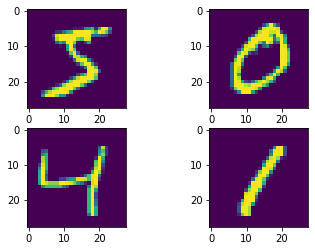

In [3]:
#let's take a look at some examples of our dataset

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(train_dataset[0][0][0])
axs[0, 1].imshow(train_dataset[1][0][0])
axs[1, 0].imshow(train_dataset[2][0][0])
axs[1, 1].imshow(train_dataset[3][0][0])

plt.show()

In [4]:
# set up our data loaders
# data loaders in pytorch helps us iterate through our data in batches 

batch_size = 100

train_loader = th.utils.data.DataLoader(
                 dataset=train_dataset,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = th.utils.data.DataLoader(
                dataset=test_dataset,
                batch_size=batch_size,
                shuffle=False)

## 2. The model

We start by creating the simplest of models which is logistic regression.

In pytorch, to create your model you need to create a class that heritates from the nn.Module.

in the init function we set the model parameters.
In this case logistic regression is basically a linear transformation from the input space to our output space. so our parameters consist of a matrix of dimension input_dim x output_dim and a bias vector of length output_dim.

nn.Parameter can be seen as a wrapper that lets pytorch know that this is a model parameter so that we can later change it in the learning process

The forward function is the function that maps our input to the output using our model parameters. In our case it's a matrix multiplication of the input to which we add the bias terms.

In [5]:
class LogisticRegression(nn.Module):
  def __init__(self, input_dim, output_dim):
      super().__init__()
      self.weights = nn.Parameter(th.randn(input_dim, output_dim) / math.sqrt(input_dim))
      self.bias = nn.Parameter(th.zeros(output_dim))

  def forward(self, xb):
      return xb @ self.weights + self.bias

In [6]:
#let's initialize our first model

#each image is represented by 28x28 pixels
input_dim = 28*28 

#the output is a vector of probabilities which indicates to which label we assign the result
#in our case we can have 10 possible outputs
output_dim = 10 

logistic_regression = LogisticRegression(input_dim, output_dim)

## 3. The criterion and the optimizer

Pytorch offers different loss functions, or the criterion as we call them. Each suits different problems and situations

We should note that in the deep learning realm, all the optimizers lays around one fundamental concept which is the gradients. By computing the gradient of the parameters according to the criterion function it updates the model.

Pytorch offers different set of optimizers that we'll explore more later.

In [7]:
#we use the cross entropy loss
criterion = nn.CrossEntropyLoss()

#The optimizer takes the model parameters as an input
optimizer = th.optim.SGD(logistic_regression.parameters(), lr=0.01)



## 4. Training and evaluation

Now comes the learning part.

we iterate through our dataset in batches using our dataloader.
in each iteration we sample an output through our model, we calculate our loss using the criterion function. Using this loss the optimizer will update the model.

we do this through different epochs. And at each epoch we also evaluate the performance of our model by calculating the accuracy of the predictions (number of correct predictions / number of predictions)

In [ ]:
from tqdm import tqdm

EPOCHS = 25
loop = tqdm(range(EPOCHS), leave=True)

# We keep track of the loss history and error (100 - accuracy) throughout training
loss_history = []
error_history = []
accuracy = 0
for epoch in loop:
  loop.set_description(f'Epoch {epoch}')
  for imgs, labels in train_loader:
    optimizer.zero_grad()

    # sample the outputs
    outputs = logistic_regression(imgs.view(-1, input_dim))
    # calculate our loss
    loss = criterion(outputs, labels)
    # this calculates the gradients
    loss.backward()
    # the optimizer updates our model
    optimizer.step()
    loss_history.append(loss.item())
    loop.set_postfix(loss=loss.item(), accuracy=accuracy)

  # calculate accuracy on test set
  correct = 0
  for imgs, labels in test_loader:
    outputs = logistic_regression(imgs.view(-1, input_dim))
    #get the predictions
    predicted = th.argmax(outputs.data, 1)
    # calculate the number of correct predictions
    correct += (predicted == labels).sum()

  accuracy = 100 * correct/len(test_dataset)
  error_history.append(100 - accuracy.item())
  loop.set_postfix(loss=loss.item(), accuracy=accuracy.item())

Epoch 24: 100%|██████████| 25/25 [04:32<00:00, 10.89s/it, accuracy=91.4, loss=0.322]


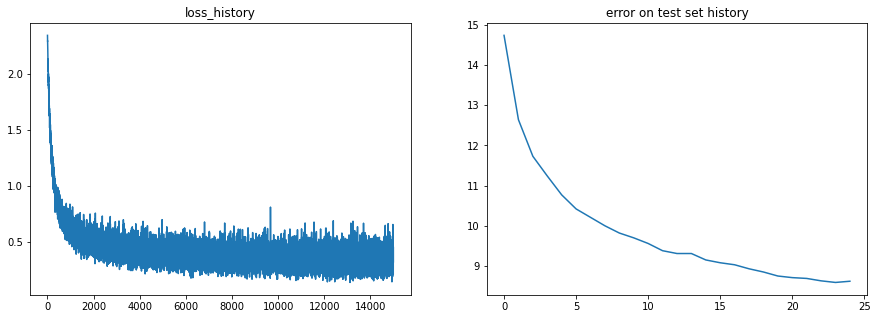

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
ax1.plot(loss_history)
ax1.set_title("loss_history")
ax2.plot(error_history)
ax2.set_title("error on test set history")

plt.show()

We see that with a logistic regression model we hit a performance of **91%** which is already good, knowing that we achieve that using only a linear transformation of the input to the output. It's also interesting to see in the graphs how the training happens through iterations and how the performance improves.

## Neural networks

Now that we had our first touch with the full stack of a DL stack (with a very simple model, in fact logistic regression isn't even considered as part of DL but ML). Now we'll jump to neural networks.

So what is a neural network anyway?

A neural network is simply a sequence of linear transformations. We begin from our input, we perform these linear transformations throughout different layers to get what we call hidden representations. After each layer we pass the result through an activation function, which is just a non-linear function, its purpose is to break the linearity. If we don't break the linearity our whole model turns into one simple liner transformation (just like logistic regression), which is not what we want. 
And we do this until we arrive to the final layer which is the output space.

![Neural networks](https://miro.medium.com/max/1100/1*YgJ6SYO7byjfCmt5uV0PmA.png)

The intuition behind all of this is that at each layer we get a better representation of the input data. A neural network can help us approximate more and very complex functions than what simple logistic regression model can, which is its power.

Pytorch has the Linear class which applies these linear transformations (we don't need to do them ourselves like in the logistic regression example), and provides us with different activation functions.

In [8]:
#we'll build a neural network with only one hidden layer
class NeuralNet(nn.Module):
  def __init__(self, input_dim, hidden_size, output_dim):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_size)
    self.linear2 = nn.Linear(hidden_size, output_dim)
    self.activ = nn.Sigmoid()

  def forward(self, x):
    a = self.linear1(x)
    a = self.activ(a)
    output = self.linear2(a)
    return output

In [9]:
hidden_size = 128
net = NeuralNet(input_dim, hidden_size, output_dim)

#the optimizer and the criterion will remain the same only the model changes
optimizer = th.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
#notice how most of things don't change, only our model changes

EPOCHS = 25
loop = tqdm(range(EPOCHS), leave=True)

nn_loss_history = []
nn_error_history = []
nn_accuracy = 0
for epoch in loop:
  loop.set_description(f'Epoch {epoch}')
  for imgs, labels in train_loader:
    optimizer.zero_grad()

    outputs = net(imgs.view(-1, input_dim))
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    nn_loss_history.append(loss.item())
    loop.set_postfix(loss=loss.item(), accuracy=nn_accuracy)

  # calculate accuracy on test set
  correct = 0
  for imgs, labels in test_loader:
    outputs = net(imgs.view(-1, input_dim))
    predicted = th.argmax(outputs.data, 1)
    correct += (predicted == labels).sum()

  nn_accuracy = 100 * correct/len(test_dataset)
  nn_error_history.append(100 - nn_accuracy.item())
  loop.set_postfix(loss=loss.item(), accuracy=nn_accuracy.item())

Epoch 24: 100%|██████████| 25/25 [04:27<00:00, 10.69s/it, accuracy=90.5, loss=0.467]


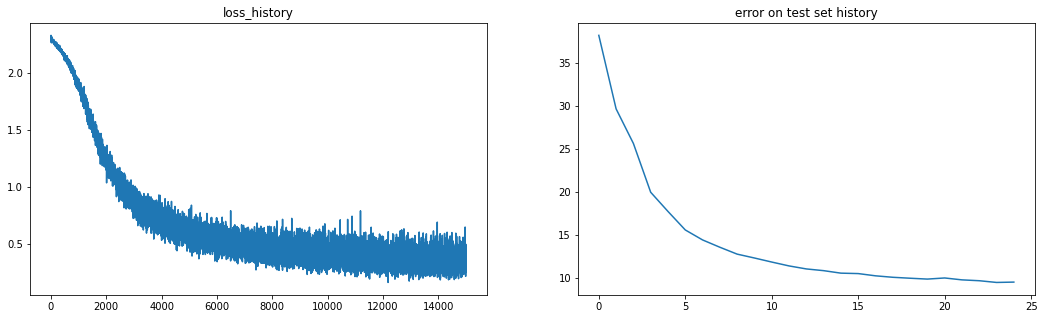

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
ax1.plot(nn_loss_history)
ax1.set_title("loss_history")
ax2.plot(nn_error_history)
ax2.set_title("error on test set history")

plt.show()

Theoraticaly the neural network should improve the performance, it's not what we notice in this case. It even decreased.

In the following we'll still stick to the same architecture, with only one hidden layer. Because we can change our ANN (artificial neural network) architecture to have multiple hidden layers and we can see if it gives better results, but it's not what we'll do.

This will allow us to see how neural networks can improve by different techniques and hyperparameter tuning.

## And what are hyperparameters?
Hyperparameters are a set of parameters that are inputs to our algorithm during training (they're parameters that the algorithms doesn't learn). So it's up to us to set them right.

For example, the one that we'll start with is the learning rate. And this parameter we provide for the optimizer and which indicates the rate at which our model learns.

What we can do is try different learning rate values and pick the best option. This way we can hopefully have a good learning rate that'll allow the model to learn quickly and well (reach convergence and optimal solution).

In [ ]:
net1 = NeuralNet(input_dim, hidden_size, output_dim)
optimizer1 = th.optim.SGD(net1.parameters(), lr=0.1)

net2 = NeuralNet(input_dim, hidden_size, output_dim)
optimizer2 = th.optim.SGD(net2.parameters(), lr=0.01)

net3 = NeuralNet(input_dim, hidden_size, output_dim)
optimizer3 = th.optim.SGD(net3.parameters(), lr=0.001)

#lastly we'll explore if setting up a learning rate decay helps
#learning rate decay is basically decreasing the value of learning rate through time
net4 = NeuralNet(input_dim, hidden_size, output_dim)
optimizer4 = th.optim.SGD(net4.parameters(), lr=0.1)
scheduler = th.optim.lr_scheduler.StepLR(optimizer4, step_size=5, gamma=0.2)

In [ ]:
EPOCHS = 25
loop = tqdm(range(EPOCHS), leave=True)

loss1_history = []
loss2_history = []
loss3_history = []
loss4_history = []
for epoch in loop:
  loop.set_description(f'Epoch {epoch}')

  losses1 = []
  losses2 = []
  losses3 = []
  losses4 = []
  for imgs, labels in train_loader:
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    optimizer4.zero_grad()

    outputs1 = net1(imgs.view(-1, input_dim))
    loss1 = criterion(outputs1, labels)
    loss1.backward()
    optimizer1.step()
    losses1.append(loss1.item())

    outputs2 = net2(imgs.view(-1, input_dim))
    loss2 = criterion(outputs2, labels)
    loss2.backward()
    optimizer2.step()
    losses2.append(loss2.item())

    outputs3 = net3(imgs.view(-1, input_dim))
    loss3 = criterion(outputs3, labels)
    loss3.backward()
    optimizer3.step()
    losses3.append(loss3.item())

    outputs4 = net4(imgs.view(-1, input_dim))
    loss4 = criterion(outputs4, labels)
    loss4.backward()
    optimizer4.step()
    losses4.append(loss4.item())

    loop.set_postfix(loss1=loss1.item(), loss2=loss2.item(), loss3=loss3.item(), loss4=loss4.item())

  scheduler.step()

  loss1_history.append(np.mean(losses1))
  loss2_history.append(np.mean(losses2))
  loss3_history.append(np.mean(losses3))
  loss4_history.append(np.mean(losses4))

Epoch 24: 100%|██████████| 25/25 [06:07<00:00, 14.70s/it, loss1=0.0458, loss2=0.238, loss3=1.57, loss4=0.128]


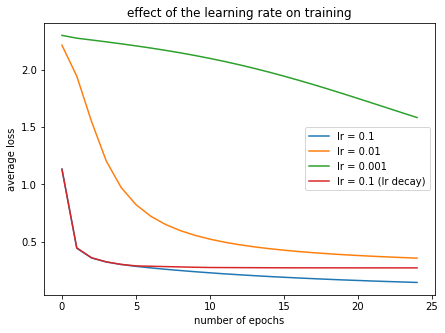

In [ ]:
x = np.arange(EPOCHS)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x, loss1_history, label='lr = 0.1') 
ax.plot(x, loss2_history, label='lr = 0.01') 
ax.plot(x, loss3_history, label='lr = 0.001') 
ax.plot(x, loss4_history, label='lr = 0.1 (lr decay)') 

ax.set_xlabel('number of epochs')
ax.set_ylabel('average loss') 
ax.set_title("effect of the learning rate on training") 
ax.legend()

plt.show()

We can already see the effect of changing the learning rate on how the model learns thoughout the training. And clearly learning rate of 0.1 is what works best.

Let's evaluate it and see the accuracy of the model trained with a learning rate of 0.1

In [ ]:
correct = 0
for imgs, labels in test_loader:
  outputs = net1(imgs.view(-1, input_dim))
  predicted = th.argmax(outputs.data, 1)
  correct += (predicted == labels).sum()

accuracy = 100 * correct/len(test_dataset)

print(f"accuracy : {accuracy}")

accuracy : 95.69999694824219


Just finetuning the learning rate already boosted the accuracy of the model with no other modification.

## optimizer algorithm:
Next we'll explore different optimizer algorithms, we'll compare mainly three optimizers: SGD, RMSProp and adam.

In [10]:
lr = 0.1
net1 = NeuralNet(input_dim, hidden_size, output_dim)
optimizer1 = th.optim.SGD(net1.parameters(), lr=lr)

net2 = NeuralNet(input_dim, hidden_size, output_dim)
optimizer2 = th.optim.RMSprop(net2.parameters(), lr=lr)

net3 = NeuralNet(input_dim, hidden_size, output_dim)
optimizer3 = th.optim.Adam(net3.parameters(), lr=lr)

In [ ]:
EPOCHS = 25
loop = tqdm(range(EPOCHS), leave=True)

loss1_history = []
loss2_history = []
loss3_history = []
for epoch in loop:
  loop.set_description(f'Epoch {epoch}')

  losses1 = []
  losses2 = []
  losses3 = []
  for imgs, labels in train_loader:
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    optimizer4.zero_grad()

    outputs1 = net1(imgs.view(-1, input_dim))
    loss1 = criterion(outputs1, labels)
    loss1.backward()
    optimizer1.step()
    losses1.append(loss1.item())

    outputs2 = net2(imgs.view(-1, input_dim))
    loss2 = criterion(outputs2, labels)
    loss2.backward()
    optimizer2.step()
    losses2.append(loss2.item())

    outputs3 = net3(imgs.view(-1, input_dim))
    loss3 = criterion(outputs3, labels)
    loss3.backward()
    optimizer3.step()
    losses3.append(loss3.item())

    loop.set_postfix(loss1=loss1.item(), loss2=loss2.item(), loss3=loss3.item())


  loss1_history.append(np.mean(losses1))
  loss2_history.append(np.mean(losses2))
  loss3_history.append(np.mean(losses3))

Epoch 24: 100%|██████████| 25/25 [07:35<00:00, 18.22s/it, loss1=0.256, loss2=0.637, loss3=0.314]


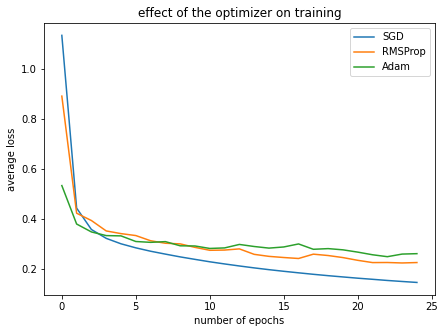

In [ ]:
x = np.arange(EPOCHS)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x, loss1_history, label='SGD') 
ax.plot(x, loss2_history, label='RMSProp') 
ax.plot(x, loss3_history, label='Adam') 

ax.set_xlabel('number of epochs')
ax.set_ylabel('average loss') 
ax.set_title("effect of the optimizer on training") 
ax.legend()

plt.show()

So it seems that the SGD optimizer gives better results.

I should point out that there are different techniques of hyperparameter techniques that do an automatic search to get the best settings, and the way we're doing it now is kind of manual.

## Activation function:

Now is the time to touch a little on the inside of the architecture. The activation function in the hidden layer can have a substantial impact on the results.
We'll explore 3 activation functions: Sigmoid, Relu and Tanh

In [11]:
class NeuralNet(nn.Module):
  def __init__(self, input_dim, hidden_size, output_dim, activ_fn):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_size)
    self.linear2 = nn.Linear(hidden_size, output_dim)
    self.activ = self.get_activ_fn(activ_fn)

  def forward(self, x):
    a = self.linear1(x)
    a = self.activ(a)
    output = self.linear2(a)
    return output

  def get_activ_fn(self, activ_fn):
    if activ_fn == 'sigmoid':
      return nn.Sigmoid()
    elif activ_fn == 'relu':
      return nn.ReLU()
    elif activ_fn == 'tanh':
      return nn.Tanh()
    

In [ ]:
net1 = NeuralNet(input_dim, hidden_size, output_dim, 'sigmoid')
optimizer1 = th.optim.SGD(net1.parameters(), lr=lr)

net2 = NeuralNet(input_dim, hidden_size, output_dim, 'relu')
optimizer2 = th.optim.SGD(net2.parameters(), lr=lr)

net3 = NeuralNet(input_dim, hidden_size, output_dim, 'tanh')
optimizer3 = th.optim.SGD(net3.parameters(), lr=lr)

In [ ]:
EPOCHS = 25
loop = tqdm(range(EPOCHS), leave=True)

loss1_history = []
loss2_history = []
loss3_history = []
for epoch in loop:
  loop.set_description(f'Epoch {epoch}')

  losses1 = []
  losses2 = []
  losses3 = []
  for imgs, labels in train_loader:
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    optimizer4.zero_grad()

    outputs1 = net1(imgs.view(-1, input_dim))
    loss1 = criterion(outputs1, labels)
    loss1.backward()
    optimizer1.step()
    losses1.append(loss1.item())

    outputs2 = net2(imgs.view(-1, input_dim))
    loss2 = criterion(outputs2, labels)
    loss2.backward()
    optimizer2.step()
    losses2.append(loss2.item())

    outputs3 = net3(imgs.view(-1, input_dim))
    loss3 = criterion(outputs3, labels)
    loss3.backward()
    optimizer3.step()
    losses3.append(loss3.item())

    loop.set_postfix(loss1=loss1.item(), loss2=loss2.item(), loss3=loss3.item())


  loss1_history.append(np.mean(losses1))
  loss2_history.append(np.mean(losses2))
  loss3_history.append(np.mean(losses3))

Epoch 24: 100%|██████████| 25/25 [04:53<00:00, 11.74s/it, loss1=0.132, loss2=0.0102, loss3=0.0336]


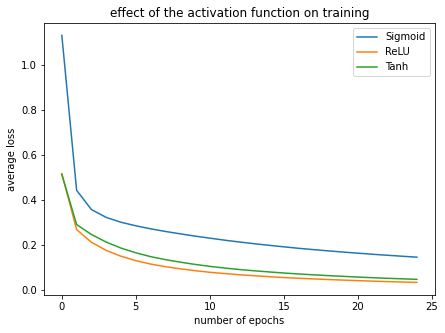

In [ ]:
x = np.arange(EPOCHS)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x, loss1_history, label='Sigmoid') 
ax.plot(x, loss2_history, label='ReLU') 
ax.plot(x, loss3_history, label='Tanh') 

ax.set_xlabel('number of epochs')
ax.set_ylabel('average loss') 
ax.set_title("effect of the activation function on training") 
ax.legend()

plt.show()

We notice that Sigmoid is underperforming the other two. And ReLU seems to work best, although it's close enough with Tanh activation.

In [ ]:
correct = 0
for imgs, labels in test_loader:
  outputs = net2(imgs.view(-1, input_dim))
  predicted = th.argmax(outputs.data, 1)
  # for gpu, bring the predicted and labels back to cpu fro python operations to work
  correct += (predicted == labels).sum()

accuracy = 100 * correct/len(test_dataset)

print(f"accuracy : {accuracy}")

accuracy : 97.83000183105469


At this point, the accuracy is already very good. But we would still wonder if we can still improve it slightly better (better is always good)

## Batch normalization
Let's see if batch normalization can have a positive effect and compare to the last network

In [12]:
class NeuralNet(nn.Module):
  def __init__(self, input_dim, hidden_size, output_dim, activ_fn):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_size)
    self.linear2 = nn.Linear(hidden_size, output_dim)
    self.activ = self.get_activ_fn(activ_fn)

  def forward(self, x):
    a = self.linear1(x)
    a = F.layer_norm(a, normalized_shape=a.size()[1:])
    a = self.activ(a)
    output = self.linear2(a)
    return output

  def get_activ_fn(self, activ_fn):
    if activ_fn == 'sigmoid':
      return nn.Sigmoid()
    elif activ_fn == 'relu':
      return nn.ReLU()
    elif activ_fn == 'tanh':
      return nn.Tanh()

In [14]:
from tqdm import tqdm

activ_fn = 'relu'
net = NeuralNet(input_dim, hidden_size, output_dim, activ_fn)
optimizer = th.optim.SGD(net.parameters(), lr=lr)

EPOCHS = 25
loop = tqdm(range(EPOCHS), leave=True)

net.train()
for epoch in loop:
  loop.set_description(f'Epoch {epoch}')
  for imgs, labels in train_loader:
    optimizer.zero_grad()

    outputs = net(imgs.view(-1, input_dim))
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())

  # calculate accuracy on test set

net.eval()
correct = 0
for imgs, labels in test_loader:
  outputs = net(imgs.view(-1, input_dim))
  predicted = th.argmax(outputs.data, 1)
  # for gpu, bring the predicted and labels back to cpu fro python operations to work
  correct += (predicted == labels).sum()

accuracy = 100 * correct/len(test_dataset)
print(f"accuracy : {accuracy}")

Epoch 24: 100%|██████████| 25/25 [03:43<00:00,  8.94s/it, loss=0.0205]


accuracy : 97.88999938964844


As we notice our model approaches 98% accuracy.

## Dropout
One last configuration we might add is dropout.

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, input_dim, hidden_size, output_dim, activ_fn, rate=0.1):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_size)
    self.linear2 = nn.Linear(hidden_size, output_dim)
    self.activ = self.get_activ_fn(activ_fn)
    self.rate = rate

  def forward(self, x, training=True):
    a = self.linear1(x)
    a = F.layer_norm(a, normalized_shape=a.size()[1:])
    a = self.activ(a)
    a = F.dropout(a, p=self.rate, training=training)
    output = self.linear2(a)
    return output

  def get_activ_fn(self, activ_fn):
    if activ_fn == 'sigmoid':
      return nn.Sigmoid()
    elif activ_fn == 'relu':
      return nn.ReLU()
    elif activ_fn == 'tanh':
      return nn.Tanh()

In [ ]:
net = NeuralNet(input_dim, hidden_size, output_dim, activ_fn)
optimizer = th.optim.SGD(net.parameters(), lr=lr)

EPOCHS = 25
loop = tqdm(range(EPOCHS), leave=True)

net.train()
for epoch in loop:
  loop.set_description(f'Epoch {epoch}')
  for imgs, labels in train_loader:
    optimizer.zero_grad()

    outputs = net(imgs.view(-1, input_dim))
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())

net.eval()
correct = 0
for imgs, labels in test_loader:
  outputs = net(imgs.view(-1, input_dim), training=False)
  predicted = th.argmax(outputs.data, 1)
  # for gpu, bring the predicted and labels back to cpu fro python operations to work
  correct += (predicted == labels).sum()

accuracy = 100 * correct/len(test_dataset)
print(f"accuracy : {accuracy}")

Epoch 24: 100%|██████████| 25/25 [03:56<00:00,  9.48s/it, loss=0.0608]


accuracy : 97.80000305175781


Dropout doesn't seem to get us better result, and this might be due to the fact that batch normalization eliminates the need of Dropout, cause BN provides sometimes similar regularization benefits as Dropout intuitively.

**In conclusion** our final architecture and hyperparameters look like the following:
Note that we can always find a better architecture that gets better result, by changing the number of layers, or the dimension of the hidden size or even use CNNs -convolutional neural networks- for that matter (the best mnist classifier achieves 99.8 accuracy and uses CNNs). 

In [15]:
class NeuralNet(nn.Module):
  def __init__(self, input_dim, hidden_size, output_dim, activ_fn):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, hidden_size)
    self.linear2 = nn.Linear(hidden_size, output_dim)
    self.activ = self.get_activ_fn(activ_fn)

  def forward(self, x):
    a = self.linear1(x)
    a = F.layer_norm(a, normalized_shape=a.size()[1:])
    a = self.activ(a)
    output = self.linear2(a)
    return output

  def get_activ_fn(self, activ_fn):
    if activ_fn == 'sigmoid':
      return nn.Sigmoid()
    elif activ_fn == 'relu':
      return nn.ReLU()
    elif activ_fn == 'tanh':
      return nn.Tanh()

In [16]:
input_dim = 28*28
hidden_size = 128
output_dim = 10
activ_fn = 'relu'
lr = 0.1

net = NeuralNet(input_dim, hidden_size, output_dim, activ_fn)
optimizer = th.optim.SGD(net.parameters(), lr=lr)

EPOCHS = 25
loop = tqdm(range(EPOCHS), leave=True)

net.train()
for epoch in loop:
  loop.set_description(f'Epoch {epoch}')
  for imgs, labels in train_loader:
    optimizer.zero_grad()

    outputs = net(imgs.view(-1, input_dim))
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())

net.eval()
correct = 0
for imgs, labels in test_loader:
  outputs = net(imgs.view(-1, input_dim))
  predicted = th.argmax(outputs.data, 1)
  correct += (predicted == labels).sum()

accuracy = 100 * correct/len(test_dataset)
print(f"accuracy : {accuracy}")

Epoch 24: 100%|██████████| 25/25 [03:38<00:00,  8.75s/it, loss=0.0169]


accuracy : 97.80999755859375


## Saving our model

Now that we have finished our training we can save our model for later use.

In [17]:
#save trained model
PATH = '../trained-models/mnist_net.pth'
th.save(net.state_dict(), PATH)


In [18]:
#load the model
input_dim = 28*28
hidden_size = 128
output_dim = 10
activ_fn = 'relu'

PATH = '../trained-models/mnist_net.pth'
net = NeuralNet(input_dim, hidden_size, output_dim, activ_fn)
net.load_state_dict(th.load(PATH))

#using this network we can now do digit recognition 

<All keys matched successfully>

And with this we conclude the first part of our deep learning projects series. 

Overall, we implemented our first neural network to do digit recognition, and learned about hyperparameter finetuning and improving techniques.